In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import torch 
import torch.nn as nn 
from torch.autograd import Variable 
import torch.optim as optim

Start date:  1996-08-02 00:00:00
End date:  2024-08-01 00:00:00


C:\Users\nq9093\AppData\Local\Temp\ipykernel_18636\2480765251.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date'])


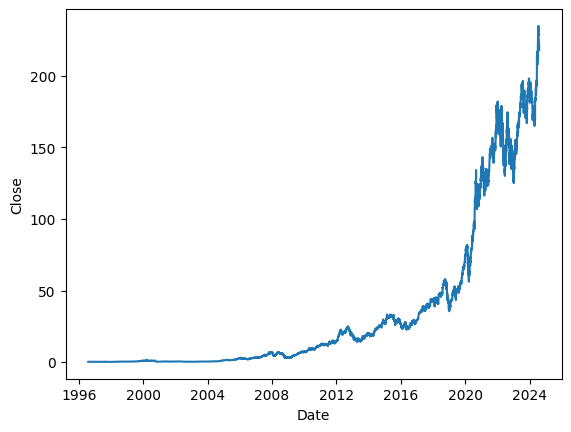

In [21]:
dataframe = pd.read_csv("AAPL.csv")
df = dataframe[['Date', 'Close']]
df['Date'] = pd.to_datetime(df['Date'])

sns.lineplot(x='Date', y='Close', data=df)
print("Start date: ", df['Date'].min())
print("End date: ", df['Date'].max())

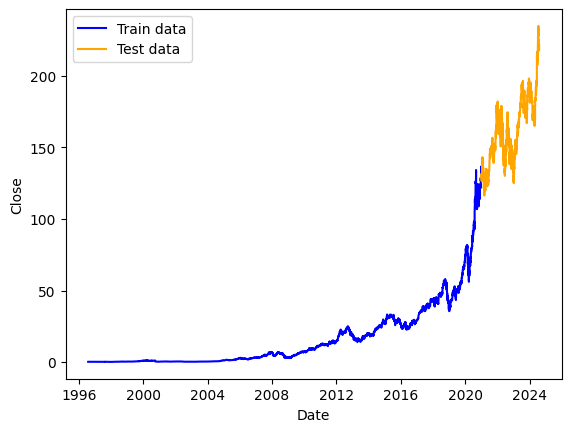

In [24]:
train_data, test_data = df.loc[df['Date'] <= "2020-12-31"], df.loc[df['Date'] > "2020-12-31"]

sns.lineplot(x='Date', y='Close', data=train_data, color='blue', label='Train data')
sns.lineplot(x='Date', y='Close', data=test_data, color='orange', label='Test data')
plt.legend()

In [25]:
window_size = 30 

def create_inout_sequences(x, y, window_size:int=1): 
    x_values = []
    y_values = []

    for i in range(len(x) - window_size):
        x_values.append(x.iloc[i:i+window_size].values)
        y_values.append(y.iloc[i+window_size])
    
    return np.array(x_values), np.array(y_values)

trainX, trainY = create_inout_sequences(train_data['Close'], train_data['Close'], window_size)
testX, testY = create_inout_sequences(test_data['Close'], test_data['Close'], window_size)

In [44]:
trainX, trainY, testX, testY = map(lambda x: torch.tensor(x, dtype=torch.float32), [trainX, trainY, testX, testY])
trainX = trainX.unsqueeze(2)
trainY = trainY.unsqueeze(1)
testX = testX.unsqueeze(2)
testY = testY.unsqueeze(1)


C:\Users\nq9093\AppData\Local\Temp\ipykernel_18636\2638530415.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  trainX, trainY, testX, testY = map(lambda x: torch.tensor(x, dtype=torch.float32), [trainX, trainY, testX, testY])


In [47]:
class LSTMAutoEncoder(nn.Module): 
    def __init__(self, window_size, n_features, embedding_dim=128): 
        super(LSTMAutoEncoder, self).__init__()
        self.window_size = window_size
        self.n_features = n_features
        self.embedding_dim = embedding_dim

        self.encoder = nn.LSTM(
            input_size=n_features, 
            hidden_size=embedding_dim, 
            num_layers=1, 
            batch_first=True
        )

        self.decoder = nn.LSTM(
            input_size=embedding_dim, 
            hidden_size=n_features,
            num_layers=1, 
            batch_first=True
        )

    def forward(self, x): 
        x, (hidden, cell) = self.encoder(x)
        x = hidden.repeat(self.window_size, 1, 1).permute(1, 0, 2)
        x, (hidden, cell) = self.decoder(x)
        return x



In [55]:
model = LSTMAutoEncoder(window_size, trainX.shape[1])
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

n_epochs = 10
batch_size = 32
train_loader = torch.utils.data.DataLoader(trainX, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(testX, batch_size=batch_size, shuffle=False)

for epoch in range(n_epochs):
    model.train()
    train_loss = 0
    for i, x_batch in enumerate(train_loader): 
        optimizer.zero_grad()
        x_batch = x_batch.permute(0, 2, 1)
        x_pred = model(x_batch)
        loss = loss_fn(x_pred, x_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    print(f'Epoch {epoch}, Loss {train_loss}')

c:\Users\nq9093\AppData\Local\anaconda3\envs\ML\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([32, 1, 30])) that is different to the input size (torch.Size([32, 30, 30])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\nq9093\AppData\Local\anaconda3\envs\ML\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([4, 1, 30])) that is different to the input size (torch.Size([4, 30, 30])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, Loss 724.3491686185201
Epoch 1, Loss 718.3958427111307
Epoch 2, Loss 719.2610247929891
Epoch 3, Loss 718.2029666701952
Epoch 4, Loss 723.6711677710215
Epoch 5, Loss 721.0984043280283
Epoch 6, Loss 737.5208563009897
Epoch 7, Loss 727.5100490252177
Epoch 8, Loss 720.4146994749705
Epoch 9, Loss 723.1753733158112


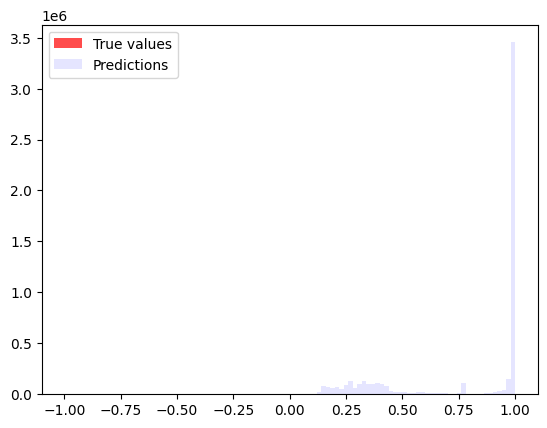

In [58]:
model.eval()
trainPredict = model(trainX.permute(0, 2, 1)).detach().numpy()
trainMAE = np.mean(np.abs(trainPredict - trainX.permute(0, 2, 1).detach().numpy()))

plt.hist(trainX.permute(0, 2, 1).detach().numpy().flatten(), bins=100, alpha=0.7, color='red', label='True values', range=[-1, 1])
plt.hist(trainPredict.flatten(), bins=100, alpha=0.1, color='blue', label='Predictions', range=[-1, 1])
plt.legend()


torch.Size([6116, 1])